In [1]:
import torch
torch.cuda.is_available()
import cupy
a = cupy.zeros((1000, 1000)) # check gpu usage

In [2]:
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Tutorial using custom genome on the PBMC bulk ATAC-seq

In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="anndata")
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import json
import csv
import re
from sklearn.preprocessing import OneHotEncoder

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

In [4]:
def density_plot(x, y, logx=False, logy=False):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    # 2D histogram binning to estimate density
    bins = 10000  # tune this for resolution/performance
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Assign each point a density based on its bin
    x_bin = np.searchsorted(xedges, x, side='right') - 1
    y_bin = np.searchsorted(yedges, y, side='right') - 1

    # Clip out-of-bound indices
    mask = (x_bin >= 0) & (x_bin < bins) & (y_bin >= 0) & (y_bin < bins)
    density = np.zeros_like(x, dtype=float)
    density[mask] = np.log10(hist[x_bin[mask], y_bin[mask]])

    # Sort by density for better visual effect
    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]
    x = np.log10(x) if logx else x
    y = np.log10(y) if logy else y
    sns.scatterplot(x=x,y=y,hue=density,linewidth=0, s=1, palette='viridis')

In [5]:
main_dir = '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man'
work_dir = f'{main_dir}/seq2print'
if not os.path.exists(work_dir):
    os.system("mkdir -p " + work_dir)
frag_dir = f'{main_dir}/fragments'
if not os.path.exists(frag_dir):
    os.system("mkdir -p " + frag_dir)

In [ ]:
# Download the fragments files of bulk samples from our Zenodo repository https://zenodo.org/records/14866808 using the code below
samples = ["Bcell_0", "Bcell_1", "Monocyte_0", "Monocyte_1", "Tcell_0", "Tcell_1"]
for sample in samples:
    link_prefix = "https://zenodo.org/records/14866808/files/PBMC_bulk_ATAC_tutorial_"
    link_suffix = "_frags.tsv.gz?download=1"
    os.system(f"wget -O {frag_dir}/{sample}_frags.tsv.gz {link_prefix}{sample}{link_suffix}")

--2025-10-31 12:27:59--  https://zenodo.org/records/14866808/files/PBMC_bulk_ATAC_tutorial_Bcell_0_frags.tsv.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92267715 (88M) [application/octet-stream]
Saving to: ‘/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz’

     0K .......... .......... .......... .......... ..........  0%  239K 6m17s
    50K .......... .......... .......... .......... ..........  0%  540K 4m32s
   100K .......... .......... .......... .......... ..........  0%  538K 3m57s
   150K .......... .......... .......... .......... ..........  0% 86.6M 2m58s
   200K .......... .......... .......... .......... ..........  0%  136M 2m22s
   250K .......... .......... .......... .......... ..........  0%  535K 2m26s
   300K .......... .......... ..

In [6]:
# Get the fragments files for individual samples
# Note: the fragments files should have 4 columns: chromosome, start, end, and barcode.
# Barcode should just be sample name, which means all fragments in the same fragments file have the same barcode.
frag_files = os.listdir(frag_dir)
frag_files = [i for i in frag_files if re.search("frags.tsv.gz", i) is not None]
frag_files = sorted([os.path.join(frag_dir, i) for i in frag_files])
samples = ["_".join(re.split("[/_\\.]", i)[11:13]) for i in frag_files]
samples

['Bcell_0', 'Bcell_1', 'Monocyte_0', 'Monocyte_1', 'Tcell_0', 'Tcell_1']

# Create scprinter & preprocessing

In [7]:
printer = scp.pp.import_fragments(
                        path_to_frags=frag_files,
                        barcodes=[None] * len(frag_files), # This loads individual fragments files and combine them
                        savename=os.path.join(work_dir, 'PBMC_bulkATAC_scprinter.h5ad'),
                        genome=scp.genome.hg38,
                        min_num_fragments=1000, min_tsse=7,
                        sorted_by_barcode=False,
                        low_memory=False,
                        )

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False


Importing fragments:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0006202427296874999, shift detected
Minimum MSE is 0.0005837050017625, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.000560113503644733, shift detected
Minimum MSE is 0.0005766687831325816, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_1_frags.tsv.gz


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00014248579643431713, shift detected
Minimum MSE is 0.00013066375045561935, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_0_frags.tsv.gz


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00015159881350813617, shift detected
Minimum MSE is 0.00012412322116221898, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_1_frags.tsv.gz


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0009582039087656653, shift detected
Minimum MSE is 0.0008927044869144165, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_0_frags.tsv.gz


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0009567918784375001, shift detected
Minimum MSE is 0.0010195613780125, shift detected
detected plus_shift and minus_shift are 4 -5 for /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_1_frags.tsv.gz


  0%|          | 0/6 [00:00<?, ?it/s]

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

start transferring insertions


In [8]:
print (printer.insertion_file.obs_names[:])

['Bcell_0', 'Bcell_1', 'Monocyte_0', 'Monocyte_1', 'Tcell_0', 'Tcell_1']


In [9]:
# Rename barcodes to sample IDs if needed.
printer.insertion_file.obs_names = samples

# Call peaks on the fragments in a preset for training seq2PRINT model

There is an existing issue with scPrinter and the calling of MACS2 for peak calling. This can be mitigated, at least in my case, by simply running the same command, but with MACS3 [1](https://github.com/buenrostrolab/scPrinter/issues/45), [2](https://github.com/buenrostrolab/scPrinter/issues/14), [3](https://github.com/buenrostrolab/scPrinter/issues/12), [4](https://github.com/buenrostrolab/scPrinter/issues/11), [5](https://github.com/buenrostrolab/scPrinter/issues/10)

```
macs2 callpeak --nomodel -t /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_1_frags.tsv.gz --outdir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
```

to

```
macs3 callpeak --nomodel -t /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_1_frags.tsv.gz --outdir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
```

and

```
macs2 callpeak --nomodel -t /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_1_frags.tsv.gz --outdir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01
```

to 

```
macs3 callpeak --nomodel -t /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Bcell_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Monocyte_1_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_0_frags.tsv.gz /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/fragments/Tcell_1_frags.tsv.gz --outdir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01
```

In [12]:
!alias macs2='macs3'

In [10]:
# Call peaks, this set of peaks are recommended to train seq2PRINT model
scp.pp.call_peaks(printer=printer,
                  frag_file=frag_files,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'],
                  preset='seq2PRINT',
                  overwrite=False)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                     sep='\t', header=False, index=False)

continue
Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 299137 peaks unresolved 295927 peaks selected
round: 2 147 peaks unresolved 143 peaks selected
finish clearing
finish sorting
finished summary


/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_369416/1374238562.py:10: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])


In [14]:
# Call peaks using chromvar preset, this set of peak are recommended to be use as cell x peak for scATAC-seq data, or analysis
scp.pp.call_peaks(printer=printer,
                  frag_file=frag_files,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['chromvar_all'],
                  preset='chromvar',
                  overwrite=False)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/regions.bed',
                     sep='\t', header=False, index=False)

continue
Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 400 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 199743 peaks unresolved 128196 peaks selected
round: 2 21079 peaks unresolved 9575 peaks selected
round: 3 4422 peaks unresolved 1535 peaks selected
round: 4 1357 peaks unresolved 392 peaks selected
round: 5 472 peaks unresolved 114 peaks selected
round: 6 186 peaks unresolved 42 peaks selected
round: 7 65 peaks unresolved 18 peaks selected
round: 8 24 peaks unresolved 5 peaks selected
round: 9 6 peaks unresolved 1 peaks selected
round: 10 1 peaks unresolved 1 peaks selected
finish clearing
finish sorting
finished summary


/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_366476/65003063.py:10: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])


In [12]:
# we can compare two sets of peaks with different preset
print (pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:]))

           0          1          2                3        4        5    6  \
0       chr1     816850     817850      all_peak_54  153.156  153.156  all   
1       chr1     826420     827420     all_peak_55a   22.458   22.458  all   
2       chr1     827037     828037     all_peak_55b    937.1    937.1  all   
3       chr1     828500     829500      all_peak_56  7.18532  7.18532  all   
4       chr1     843661     844661     all_peak_57a  6.46058  6.46058  all   
...      ...        ...        ...              ...      ...      ...  ...   
296064  chrX  155768168  155769168  all_peak_207726  7.18532  7.18532  all   
296065  chrX  155819803  155820803  all_peak_207727   28.839   28.839  all   
296066  chrX  155841026  155842026  all_peak_207728  36.7673  36.7673  all   
296067  chrX  155880773  155881773  all_peak_207729  665.752  665.752  all   
296068  chrX  155972177  155973177  all_peak_207730  2.71106  2.71106  all   

             7  
0        31046  
1        92540  
2         80

/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_144878/2415760104.py:2: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  print (pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:]))


In [13]:
print (pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:]))

           0          1          2                         3        4  \
0       chr1     817200     817500      chromvar_all_peak_35  150.718   
1       chr1     827387     827687     chromvar_all_peak_36b  933.901   
2       chr1     844607     844907     chromvar_all_peak_37d  13.7316   
3       chr1     858011     858311      chromvar_all_peak_38  14.6569   
4       chr1     865660     865960      chromvar_all_peak_40  107.404   
...      ...        ...        ...                       ...      ...   
139890  chrX  155632509  155632809  chromvar_all_peak_130192  50.4941   
139891  chrX  155767443  155767743  chromvar_all_peak_130194  22.5783   
139892  chrX  155820153  155820453  chromvar_all_peak_130195  26.8421   
139893  chrX  155841376  155841676  chromvar_all_peak_130196  34.7131   
139894  chrX  155881123  155881423  chromvar_all_peak_130197  662.749   

              5             6      7  
0       150.718  chromvar_all  25203  
1       933.901  chromvar_all   7315  
2     

/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_144878/2938188741.py:1: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  print (pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:]))


# Training separate seq2PRINT models for each sample

In [14]:
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
for sample in samples:
    # For exploratory analyses we run only one fold. For publication results you can run all 5 fold for slight improvement in accuracy.
    # If you want to run all five folds, add a for-loop layer "for fold in range(5)". This way each sample will have 5 models trained.
    fold=0
    model_config= scp.tl.seq_model_config(printer,
                                     region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                     cell_grouping=[sample],
                                     group_names=sample,
                                     genome=printer.genome,
                                     fold=fold,
                                     overwrite_bigwig=False,
                                     model_name='PBMC_bulkATAC_' + sample,
                                     additional_config={
                                        "notes": "v3",
                                        "tags": ["PBMC_bulkATAC", sample,
                                            f"fold{fold}"]},
                                     path_swap=(work_dir, ''),
                                     config_save_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON')
    model_configs.append(model_config)

Loading insertion profiles
Creating bigwig for Bcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Bcell_1


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Monocyte_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Monocyte_1


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Tcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Tcell_1


  0%|          | 0/24 [00:00<?, ?it/s]

In [15]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))

for sample in samples:
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON',
                            temp_dir=f'{work_dir}/temp',
                            model_dir=f'{work_dir}/model',
                            data_dir=work_dir,
                            gpus=samples.index(sample),
                            wandb_project='scPrinter_seq_PBMC_bulkATAC', # wandb helps you manage loggins
                            verbose=False,
                            launch=False # launch=True, this command would launch the scripts directly,
                            # otherwise, it will just display the commands, you should copy them and run them.
                           )

CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Bcell_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Bcell_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC -

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Bcell_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Bcell_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Monocyte_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Monocyte_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Tcell_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

In [ ]:
!CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/configs/PBMC_bulkATAC_Tcell_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb

# Generate TF binding scores for each sample

In [79]:
# Now fetch models:
import wandb
import json

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'mebeid'
project = 'scPrinter_seq_PBMC_bulkATAC'

# Initialize the API
api = wandb.Api()

# Get the project (get rid of two failed runs)
runs = api.runs(f"{entity}/{project}")

pretrain_models = []
model_path_dict = {}
for run in runs:
    if run.state != 'finished':
        continue
    if 'PBMC_bulkATAC' in run.tags:

        # convert run config into a proper dictionary
        json_acceptable_string = run.config.replace("'", "\"")
        d = json.loads(json_acceptable_string)

        sample = [i for i in run.tags if i in samples][0]
        model_name = d['savename']['value'] + '-' + run.name + '.pt'
        model_path = os.path.join(work_dir, "model", model_name)
        model_path_dict[sample] = model_path

model_path_dict

{'Monocyte_0': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt',
 'Tcell_1': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt'}

In [80]:
regions_dict = {
    'chr11:47378230-47379030': 'SPI1',      # Highly expressed in monocytes and B cells
    'chr5:140633035-140633835': 'CD14',     # Monocyte marker
    'chr19:41876833-41877633': 'CD79a',     # B cell marker
    'chr11:118342294-118343094': 'CD3D',    # T cell marker
    'chr17:58281312-58282112': 'MPO',       # Monocyte marker
    'chr16:31259594-31260394': 'ITGAM',     # Expressed in myeloid cells (including monocyte)
    'chr3:39281281-39282081': 'CX3CR1',     # A pretty important gene driving disease-related monocyte cell states
}

# Save example regions to a bed file
regions_df = []
for region in regions_dict:
    regions_df.append(re.split("[:-]", region))
regions_df = pd.DataFrame(regions_df)
regions_df.to_csv(f'{work_dir}/regions_test.bed',
                  sep='\t', header=False, index=False)

In [81]:
#samples = [samples[2], samples[-1]] 
samples

['Monocyte_0', 'Tcell_1']

In [83]:
import json
adata_tfbs = {}
for sample_ind, sample in enumerate(samples):
    print (f'Processing sample: {sample} ...')
    adata_tfbs[sample] = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_test.bed',
                          gpus=[0], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold0.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=True,
                          post_normalize=False,
                          save_key=f'PBMC_bulkATAC_{sample}_roi', # and input a save_key
                          save_path=work_dir)

Processing sample: Monocyte_0 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0_roi --overwrite --write_numpy --model_norm count --silent


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0_roi --overwrite --write_numpy --model_norm footprint --silent


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt_PBMC_bulkATAC_Monocyte_0_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt_PBMC_bulkATAC_Monocyte_0_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/Monocyte_0 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_Monocyte_0_roi --read_numpy --silent


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

obs=groups, var=regions
Processing sample: Tcell_1 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1_roi --overwrite --write_numpy --model_norm count --silent


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1_roi --overwrite --write_numpy --model_norm footprint --silent


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt_PBMC_bulkATAC_Tcell_1_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt_PBMC_bulkATAC_Tcell_1_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_test.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/Tcell_1 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_Tcell_1_roi --read_numpy --silent


/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

obs=groups, var=regions


chr11:47378230-47379030 SPI1


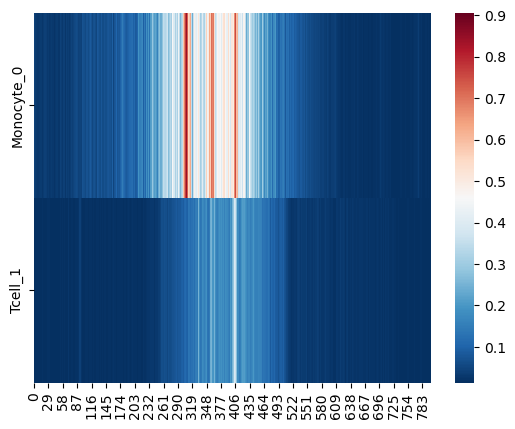

chr5:140633035-140633835 CD14


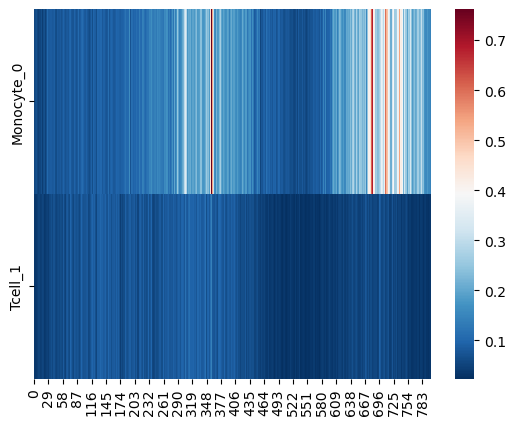

chr19:41876833-41877633 CD79a


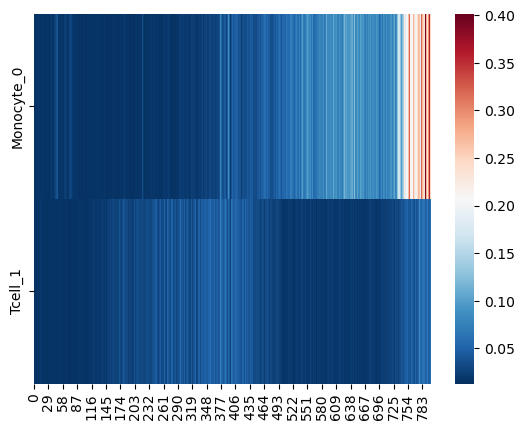

chr11:118342294-118343094 CD3D


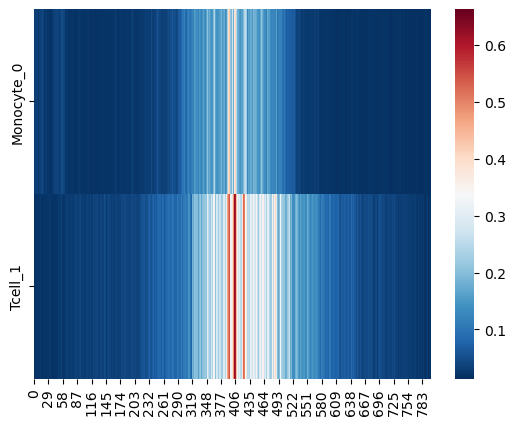

chr17:58281312-58282112 MPO


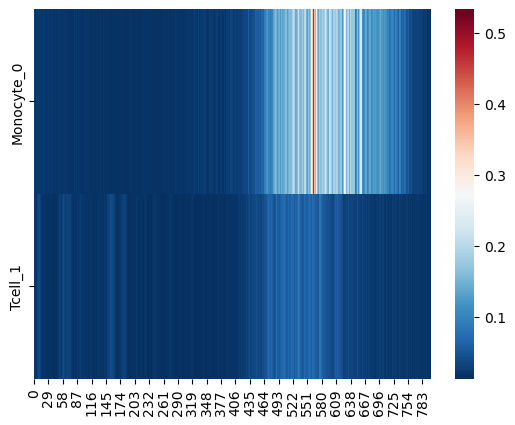

chr16:31259594-31260394 ITGAM


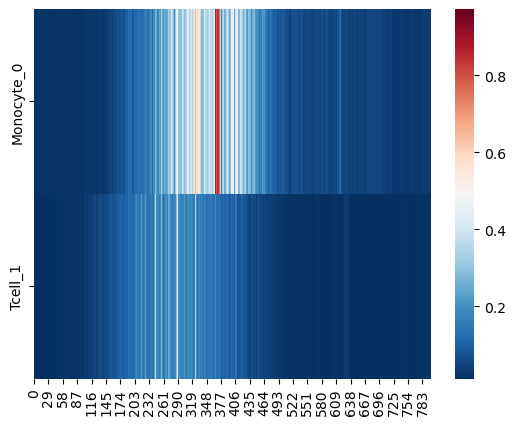

chr3:39281281-39282081 CX3CR1


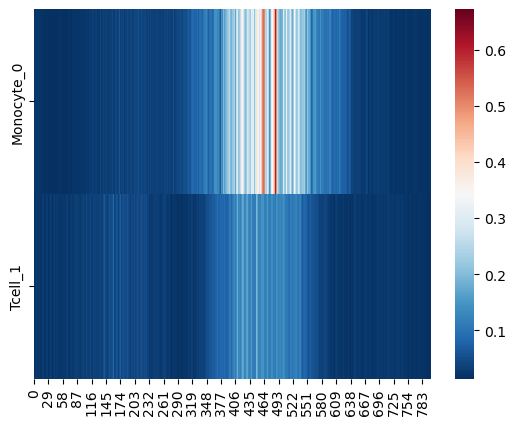

In [84]:
if not os.path.exists(f'{work_dir}/plots'):
    os.system(f'mkdir {work_dir}/plots')
for region in regions_dict.keys():
    print(region, regions_dict[region])
    tfbs = pd.DataFrame(np.array([adata_tfbs[sample].obsm[region] for sample in samples]).squeeze(), index=samples)
    sns.heatmap(tfbs, cmap='RdBu_r')
    plt.savefig(f'{work_dir}/plots/TFBS_{region}.png')
    plt.show()

# Compute TF binding scores on a larger number of peaks

In [85]:
# First construct a peak-by-cell matrix of ATAC counts
peak_path = f'{work_dir}/regions.bed'
adata = scp.pp.make_peak_matrix(printer,
                       regions=peak_path,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)
adata.write(f'{work_dir}/cell_peak.h5ad')

Making peak matrix:   0%|          | 0/139895 [00:00<?, ?it/s]

In [86]:
# Remove regions with low coverage (helps to reduce total peak number and save time. The full list of 300k peaks contains many very weak peaks)
regions = pd.read_csv(f'{work_dir}/regions.bed', sep='\t', header=None)
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
peak_depth = np.array(np.sum(adata.X, axis=0)).squeeze()
regions_filt = regions.iloc[np.where(peak_depth > 200)[0], :]
regions_filt.to_csv(f'{work_dir}/regions_filt.bed',
                     sep='\t', header=False, index=False)

In [87]:
import json
for sample_ind, sample in enumerate(samples):
    scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_filt.bed',
                          gpus=[0],
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON', 'r')),
                          group_names=[sample],
                          verbose=True,
                          launch=True,
                          return_adata=False,
                          overwrite_seqattr=True,
                          post_normalize=True,
                          save_key=f'PBMC_bulkATAC_{sample}', # and input a save_key
                          save_path=work_dir)

Automatic locating seq_attr_count
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: count
using nth_output: 0
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite --model_norm count
signal_window 1000 dna_len 1840
input summits 45431


validating loci:   0%|          | 0/45431 [00:00<?, ?it/s]

valid summits after trimming edges 45431


fetching coverage:   0%|          | 0/45431 [00:00<?, ?it/s]

(45431, 1)
coverage min max 783.4463 1418.3594
valid summits after min/max count filter 45431


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/45431 [00:00<?, ?it/s]

  0%|          | 0/45431 [00:00<?, ?it/s]

the estimated norm on prem is -0.004379082005470991 -4.148483185417717e-06 0.009308386268094146
normalizing -0.0028678893577307463 -6.965240754652768e-05 0.0038336755242198706


  0%|          | 0/39302 [00:00<?, ?it/s]

Automatic locating seq_attr_footprint
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: just_sum
using nth_output: 0-30
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite --model_norm footprint
signal_window 1000 dna_len 1840
input summits 45431


validating loci:   0%|          | 0/45431 [00:00<?, ?it/s]

valid summits after trimming edges 45431


fetching coverage:   0%|          | 0/45431 [00:00<?, ?it/s]

(45431, 1)
coverage min max 783.4463 1418.3594
valid summits after min/max count filter 45431


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/45431 [00:00<?, ?it/s]

  0%|          | 0/45431 [00:00<?, ?it/s]

the estimated norm on prem is -2.081616163253784 0.00811767578125 4.34033203125
normalizing -1.3115997314453125 -0.035317420959472656 1.8103150129318237


  0%|          | 0/39302 [00:00<?, ?it/s]

Launching the following command now (no action needed from your side)
seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt_PBMC_bulkATAC_Monocyte_0/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-ineffable-witch-3.pt_PBMC_bulkATAC_Monocyte_0/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/Monocyte_0 --gpus 0 --collection_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

gpu 0


100%|██████████| 45431/45431 [00:17<00:00, 2663.66it/s]


Automatic locating seq_attr_count
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: count
using nth_output: 0
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1 --overwrite --model_norm count
signal_window 1000 dna_len 1840
input summits 45431


validating loci:   0%|          | 0/45431 [00:00<?, ?it/s]

valid summits after trimming edges 45431


fetching coverage:   0%|          | 0/45431 [00:00<?, ?it/s]

(45431, 1)
coverage min max 783.4463 1418.3594
valid summits after min/max count filter 45431


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/45431 [00:00<?, ?it/s]

  0%|          | 0/45431 [00:00<?, ?it/s]

the estimated norm on prem is -0.0052201516460627295 2.824068178597372e-05 0.009251785464584827
normalizing -0.0035444737877696753 -4.575252751237713e-05 0.004252899554558107


  0%|          | 0/39302 [00:00<?, ?it/s]

Automatic locating seq_attr_footprint
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: just_sum
using nth_output: 0-30
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1 --overwrite --model_norm footprint
signal_window 1000 dna_len 1840
input summits 45431


validating loci:   0%|          | 0/45431 [00:00<?, ?it/s]

valid summits after trimming edges 45431


fetching coverage:   0%|          | 0/45431 [00:00<?, ?it/s]

(45431, 1)
coverage min max 783.4463 1418.3594
valid summits after min/max count filter 45431


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/45431 [00:00<?, ?it/s]

  0%|          | 0/45431 [00:00<?, ?it/s]

the estimated norm on prem is -1.905248999595642 0.018176651559770107 3.6920660853385563
normalizing -1.0958710789680481 -0.02266845665872097 1.4550293684005737


  0%|          | 0/39302 [00:00<?, ?it/s]

Launching the following command now (no action needed from your side)
seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt_PBMC_bulkATAC_Tcell_1/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-nocturnal-shadow-6.pt_PBMC_bulkATAC_Tcell_1/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/regions_filt.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/Tcell_1 --gpus 0 --collection_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/seq2print/PBMC_bulkATAC_Tce

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

gpu 0


100%|██████████| 45431/45431 [00:17<00:00, 2639.88it/s]


In [88]:
# We first scan TF motifs across all regions to find motif matched sites

# Initialize motif set object
motifs = scp.motifs.FigR_Human_Motifs(genome=printer.genome, bg=[0.25] * 4)

# Prepare motif scanner. Here you can specify which TF motifs you want to scan using tf_genes. If tf_genes=None then use all motifs
motifs.prep_scanner()

# Scan motif sites. This will return the exact genomic coordinates of motif matches
motif_sites = motifs.scan_motif(regions_filt, verbose=True, clean=True)

# Reformat motif matches to a pandas DataFrame
motif_sites = pd.DataFrame(motif_sites)
motif_sites.iloc[:, 2] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 8]
motif_sites.iloc[:, 1] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 7]
motif_sites = motif_sites.iloc[:, [0,1,2,4]]
motif_sites.columns=["chrom", "start", "end", "TF"]

  0%|          | 0/90862 [00:00<?, ?it/s]

In [89]:
# We then extract the TF binding scores at those motif sites
def fetch_bw(args):
    import pyBigWig as pw

    TFBS, bw, genome = args
    chroms, starts, ends = np.array(TFBS['chrom']),np.array(TFBS['start']),np.array(TFBS['end'])
    res_all = {}
    with pw.open(bw, 'r') as f:
        for chrom in tqdm(genome.chrom_sizes):
            if chrom == 'chrY':
                continue
            res_all[chrom] = f.values(chrom, 0, genome.chrom_sizes[chrom], numpy=True)

    vs = []
    for chr, left, right in zip(tqdm(chroms, mininterval=1), starts, ends):
        vs.append(np.nanmean(res_all[chr][left:right]))
    return vs

# Multi-process loading of TF binding scores
bigwig_dict = {sample:f"{work_dir}/{sample}_TFBS.bigwig" for sample in samples}
args = [[motif_sites, bigwig_dict[sample], printer.genome] for sample in samples]
n_jobs = 4
import multiprocessing as mp
with mp.Pool(n_jobs) as pool:
    TFBS_scores = list(pool.imap(fetch_bw, args))
TFBS_scores = np.array(TFBS_scores).T
TFBS_scores = pd.DataFrame(TFBS_scores, columns=[f"TFBS_{sample}" for sample in samples])
TFBS_scores = pd.concat([motif_sites, TFBS_scores], axis=1)

KeyError: "['TFBS_Monocyte_1'] not in index"

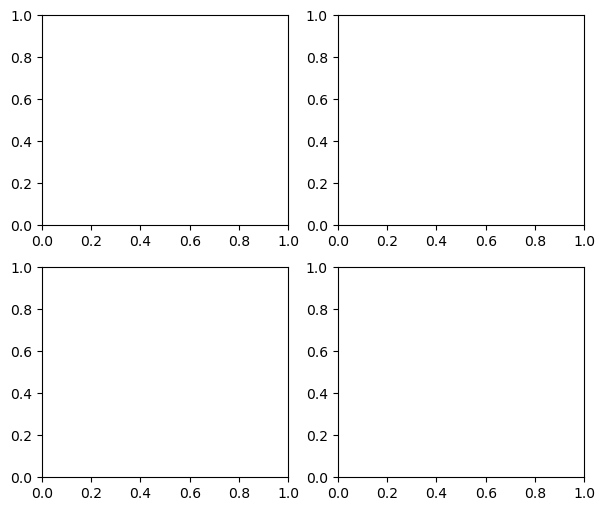

In [90]:
fig, ax = plt.subplots(2,2, figsize=(7,6))

scores = TFBS_scores.loc[TFBS_scores.TF.values == "CEBPA", :]
ax[0][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_Monocyte_{i}" for i in range(2)]], axis=1),
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[0][0].set_xlabel("Monocyte TFBS")
ax[0][0].set_ylabel("T cell TFBS")
ax[0][0].set_title("CEBPA")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "SPI1", :]
ax[0][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1),
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[0][1].set_xlabel("T cell TFBS")
ax[0][1].set_ylabel("B cell TFBS")
ax[0][1].set_title("SPI1")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "PAX5", :]
ax[1][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1),
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[1][0].set_xlabel("T cell TFBS")
ax[1][0].set_ylabel("B cell TFBS")
ax[1][0].set_title("PAX5")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "RUNX3", :]
ax[1][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1),
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[1][1].set_xlabel("T cell TFBS")
ax[1][1].set_ylabel("B cell TFBS")
ax[1][1].set_title("RUNX3")

plt.show()

In [ ]:
scores = TFBS_scores.loc[TFBS_scores.TF.values == "RUNX3", :]
Tcell_scores = np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1)
Bcell_scores = np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1)
diff = Tcell_scores - Bcell_scores
diff = diff[np.abs(diff) > 0.05]
plt.hist(diff, bins=100)
plt.show()

In [ ]:
printer.close()